In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import threading
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from transformers import BertTokenizer, BertConfig,AdamW, BertForSequenceClassification,get_linear_schedule_with_warmup
import seaborn as sns
import matplotlib.pyplot as plt
import os
import umap
import matplotlib.pyplot as plt
import glob

In [2]:
twitter=pd.read_csv("nfkd_tweets_lowercase_wopunct_wostop_woemoji_wourl.csv")

In [3]:
twitter.head(5)

,created_at,full_text,screen_name,location,description,followers_count,friends_count,statuses_count,verified,full_retweet_text
0,2020-01-22 00:14:08+00:00,rt fredros inc dear friends please spare min...,epigiri,Bengaluru India,UX and product at getmarkk Food Design Startup...,9845,1423,36903,False,Dear friends please spare a few minutes amp re...
1,2020-01-22 01:05:22+00:00,rt mariettadaviz breaking news cdc says us ...,NeerajK_,Mumbai India,NationFirst,847,424,57579,False,Breaking News CDC says the US now has its firs...
2,2020-01-22 09:10:07+00:00,china issues travel advisory deaths due ncov...,GetNewsd,New Delhi India,I am blogger and youtuber and Im express my vi...,18527,166,79182,True,No Value Mentioned
3,2020-01-22 11:19:10+00:00,rt mohfw india novel coronavirus update passen...,docvjg,New Delhi India,Official Twitter Handle of NSUI Bilaspur,3120,3767,20597,False,Novel coronavirus update passengers from fligh...
4,2020-01-22 11:26:59+00:00,rt international health regulations emergenc...,WHOSEARO,New Delhi India,YO Beyotch,72008,743,8824,True,The International Health Regulations Emergency...


# Lets Take Further Analysis On Original Post

(array([64983.,     0.,     0., 45092.,     0.,     0., 23017.,     0.,
            0., 22038.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

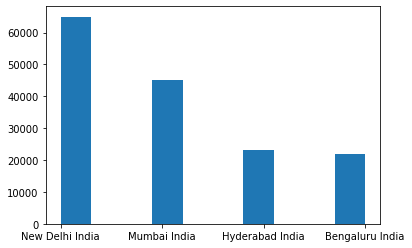

In [4]:
plt.hist(twitter[twitter.full_retweet_text=="No Value Mentioned"].location.values)


In [5]:
twitter=twitter[twitter.full_retweet_text=="No Value Mentioned"]
twitter.index=pd.to_datetime(twitter.created_at)
twitter.drop("created_at",axis=1,inplace=True)

In [8]:
def days_to_week_sorter(twitter,city):
        tweets=[]
        timeline=[]
        weekly_df=pd.DataFrame()
        twitter[twitter.location==city].full_text.values
        index=[]
        for week in twitter.index.week.unique():
                this_weeks_data = twitter[twitter.index.week == week]
                tweets.append([this_weeks_data.full_text.values[i] for i in range(len(this_weeks_data.full_text.values))])
                timeline.append(str(this_weeks_data.index[0])+"-"+str(this_weeks_data.index[-1]))
                index.append(str(this_weeks_data.index[0]))
        weekly_df["timeline"]=timeline
        weekly_df["tweets"]=tweets
        weekly_df.index=index
        return weekly_df

In [37]:
#seperated each city news in week wise format
bengaluru=days_to_week_sorter(twitter,"Bengaluru India")
delhi=days_to_week_sorter(twitter,"New Delhi India")
hyderabad=days_to_week_sorter(twitter,"Hyderabad India")
mumbai=days_to_week_sorter(twitter,"Mumbai India")

In [15]:
model=torch.load("emotion_sentiment.pt").to("cuda:0")
labels_mapping={'sadness': 4, 'joy': 2, 'anger': 0, 'fear': 1, 'surprise': 5}
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)


C:\Users\akshe\Miniconda3\lib\site-packages\torch\serialization.py:593: SourceChangeWarning: source code of class 'transformers.modeling_bert.BertSelfAttention' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [49]:
#these functions are used to fit tweets to emotions
def emotion_classifier(text):
    test_data=tokenizer.encode_plus(
      text,
      max_length=32,
      add_special_tokens=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    pred=model(test_data["input_ids"].to("cuda:0"),test_data["attention_mask"].to("cuda:0"))[0].to("cpu").detach().numpy()
    return np.argmax(pred)
def emotion_postproc_p(news_emotions,emotion):
    number_of_emotion_week=[]
    for i in news_emotions:
        emotion_count_this_week=0
        for j in i:
            if j==emotion:
                emotion_count_this_week+=1
        number_of_emotion_week.append((emotion_count_this_week/len(i))*100)
    return number_of_emotion_week
def emotion_postproc(news_emotions,emotion):
    number_of_emotion_week=[]
    for i in news_emotions:
        emotion_count_this_week=0
        for j in i:
            if j==emotion:
                emotion_count_this_week+=1
        number_of_emotion_week.append(emotion_count_this_week)
    return number_of_emotion_week
def god_function(city,city_name):
    news_emotion=[[emotion_classifier(j) for j in i] for i in city.tweets.values]
    city["fear_percentage"]=emotion_postproc_p(news_emotions,1)
    city["anger_percentage"]=emotion_postproc_p(news_emotions,0)
    city["sadness_percentage"]=emotion_postproc_p(news_emotions,4)
    city["joy_percentage"]=emotion_postproc_p(news_emotions,2)
    city["surprise_percentage"]=emotion_postproc_p(news_emotions,5)
    city["fear"]=emotion_postproc(news_emotions,1)
    city["anger"]=emotion_postproc(news_emotions,0)
    city["sadness"]=emotion_postproc(news_emotions,4)
    city["joy"]=emotion_postproc(news_emotions,2)
    city["surprise"]=emotion_postproc(news_emotions,5)
    city.to_csv(str(city_name)+"-tweets-emotions.csv")
    return city

In [50]:
bengaluru=god_function(bengaluru,"bengaluru")
delhi=god_function(delhi,"delhi")

(array([-2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]),
 <a list of 10 Text xticklabel objects>)

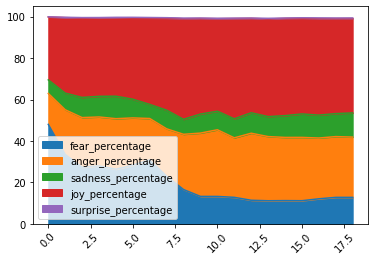

In [46]:
bengaluru.drop(["fear","anger","sadness","joy","surprise"],axis=1).plot.area()
plt.xticks(rotation=45)

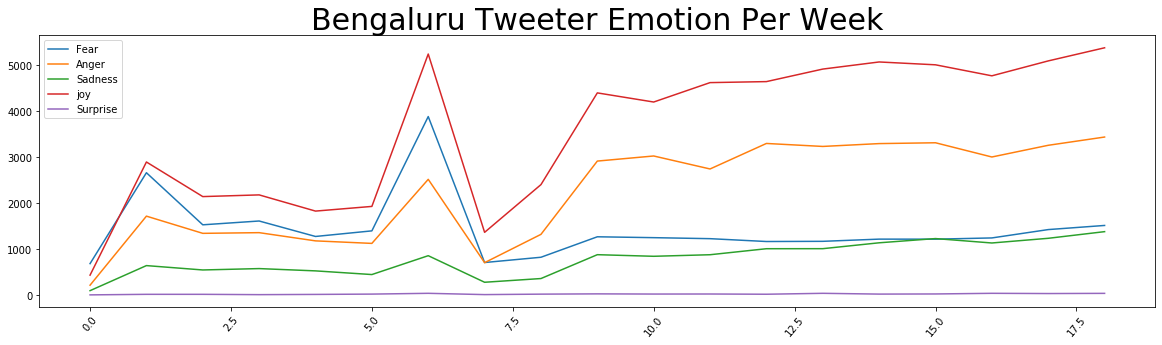

In [47]:
plt.figure(figsize=(20,5))
plt.plot(bengaluru.index,bengaluru.fear)
plt.xticks(rotation=50)
plt.plot(bengaluru.index,bengaluru.anger)
plt.plot(bengaluru.index,bengaluru.sadness)
plt.plot(bengaluru.index,bengaluru.joy)
plt.plot(bengaluru.index,bengaluru.surprise)
plt.legend(["Fear","Anger","Sadness","joy","Surprise"])
plt.title("Bengaluru Tweeter Emotion Per Week",fontsize=30)
plt.savefig("bengaluru-emotion.png")

(array([-2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]),
 <a list of 10 Text xticklabel objects>)

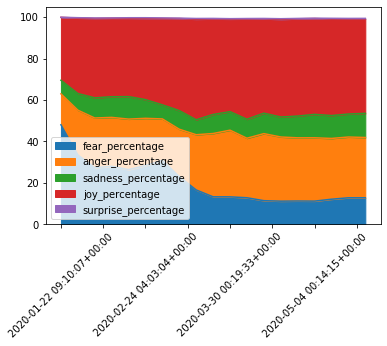

In [51]:
delhi.drop(["fear","anger","sadness","joy","surprise"],axis=1).plot.area()
plt.xticks(rotation=45)

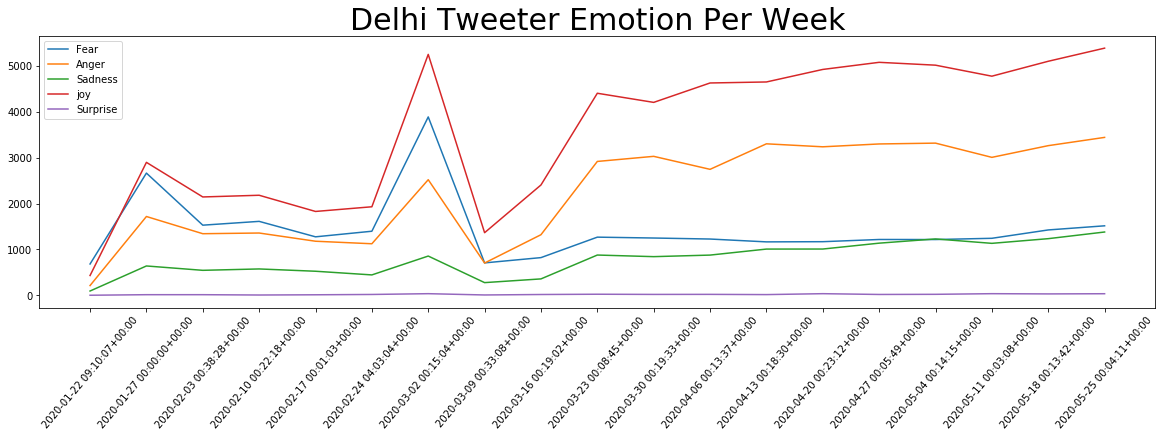

In [52]:
plt.figure(figsize=(20,5))
plt.plot(delhi.index,delhi.fear)
plt.xticks(rotation=50)
plt.plot(delhi.index,delhi.anger)
plt.plot(delhi.index,delhi.sadness)
plt.plot(delhi.index,delhi.joy)
plt.plot(delhi.index,delhi.surprise)
plt.legend(["Fear","Anger","Sadness","joy","Surprise"])
plt.title("Delhi Tweeter Emotion Per Week",fontsize=30)
plt.savefig("delhi-emotion.png")